# Implementation of Selfie by Sampling using Cleanlab

This notebook is the groups own implementation of Selfie. Since Selfie is motivated by sampling and refurbishing, this paper will cover the sampling aspect of the Selfie method. It is based on the CIFAR 100 dataset. The approach is to first corrupt the label of the training dataset. Then, by using cleanlab, an attempt is made to identify the wrongly labelled training data and sampling is done by removing the identified the wrongly labelled data. Then the datasets ( Original CIFAR-100, noisy CIFAR-100, and the sampled CIFAR-1000) will be run on the CNN introdued in the lecture with data augmentation where the effect of wrong labels and sampling on the test accuracy could be visualized. The results shown that the CNN run on original CIFAR has a test accuracy of 45%, then changing the label of 70% of the training data would cause the test accuracy to be at 15% and finally, the sampling method has managed to improve the performance to test accuracy of 40%. Although this is not a like for like implementation of Selfie, it serves as a foundation to understand the motivation of Selfie.

In [43]:
from __future__ import (print_function, absolute_import, division,
                        unicode_literals, with_statement)
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
import numpy as np
from cleanlab.classification import LearningWithNoisyLabels
from cleanlab.noise_generation import generate_noisy_labels
from cleanlab.util import value_counts
from cleanlab.latent_algebra import compute_inv_noise_matrix
from keras.utils import to_categorical
from keras.datasets import cifar100
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [44]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

In [45]:
X_train = x_train
X_test = x_test

In [46]:
y_train_flat=y_train.flatten()
print(y_train_flat)

[19 29  0 ...  3  7 73]


In [47]:
y_train_ohe = to_categorical(y_train, num_classes=100)  # convert to one-hot
y_test_ohe = to_categorical(y_test, num_classes=100)

A look at the picture

In [48]:
label_dict = [
'apple', # id 0
'aquarium_fish',
'baby',
'bear',
'beaver',
'bed',
'bee',
'beetle',
'bicycle',
'bottle',
'bowl',
'boy',
'bridge',
'bus',
'butterfly',
'camel',
'can',
'castle',
'caterpillar',
'cattle',
'chair',
'chimpanzee',
'clock',
'cloud',
'cockroach',
'couch',
'crab',
'crocodile',
'cup',
'dinosaur',
'dolphin',
'elephant',
'flatfish',
'forest',
'fox',
'girl',
'hamster',
'house',
'kangaroo',
'computer_keyboard',
'lamp',
'lawn_mower',
'leopard',
'lion',
'lizard',
'lobster',
'man',
'maple_tree',
'motorcycle',
'mountain',
'mouse',
'mushroom',
'oak_tree',
'orange',
'orchid',
'otter',
'palm_tree',
'pear',
'pickup_truck',
'pine_tree',
'plain',
'plate',
'poppy',
'porcupine',
'possum',
'rabbit',
'raccoon',
'ray',
'road',
'rocket',
'rose',
'sea',
'seal',
'shark',
'shrew',
'skunk',
'skyscraper',
'snail',
'snake',
'spider',
'squirrel',
'streetcar',
'sunflower',
'sweet_pepper',
'table',
'tank',
'telephone',
'television',
'tiger',
'tractor',
'train',
'trout',
'tulip',
'turtle',
'wardrobe',
'whale',
'willow_tree',
'wolf',
'woman',
'worm',
]

labels_train = np.asarray([label_dict[u.argmax(0)] for u in y_train_ohe])
labels_test = np.asarray([label_dict[u.argmax(0)] for u in y_test_ohe])

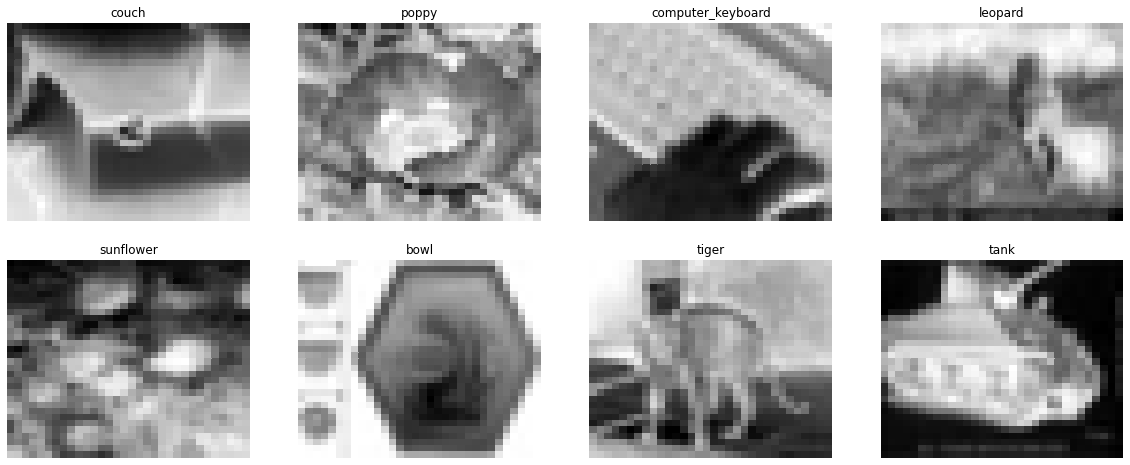

In [49]:
def plot_images(x, labels=None, nrow=2, ncol=4, im_type='image'):
    if im_type == 'filter':
        x = x.transpose(3, 0, 1, 2)  # Transpose to image type
    fig, ax = plt.subplots(nrow, ncol, figsize=(5*ncol, 4*nrow))
    num_samples = x.shape[0]
    num_channels = x.shape[-1]
    for a in ax.ravel():
        j = np.random.choice(num_samples)
        k = np.random.choice(num_channels)
        sns.heatmap(x[j, :, :, k], ax=a, cbar=False, cmap='gray_r')
        if labels is not None:
            a.set_title(labels[j])
        a.set_xticks([])
        a.set_yticks([])

plot_images(x_train, labels=labels_train)

Adding Noise to the labels

In [50]:
from cleanlab.classification import LearningWithNoisyLabels
from cleanlab.noise_generation import generate_noise_matrix_from_trace
from cleanlab.noise_generation import generate_noise_matrix
from cleanlab.noise_generation import generate_noisy_labels
from cleanlab.util import print_noise_matrix

In [51]:
noise_matrix = generate_noise_matrix(100)
print(noise_matrix)

[[0.14 0.   0.   ... 0.   0.   0.  ]
 [0.   0.49 0.   ... 0.   0.   0.  ]
 [0.   0.   0.64 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.24 0.   0.  ]
 [0.   0.   0.   ... 0.   1.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.43]]


In [131]:
py = value_counts(y_train_flat)


In [53]:
s = generate_noisy_labels(y_train_flat, noise_matrix)
print(s)

[23 97 43 ... 41 84 73]


In [54]:
y_train_noisy = to_categorical(s, num_classes=100)

A look at the images with corrupted labels

In [55]:
labels_train_noisy = np.asarray([label_dict[u.argmax(0)] for u in y_train_noisy])
labels_test_noisy = np.asarray([label_dict[u.argmax(0)] for u in y_test])

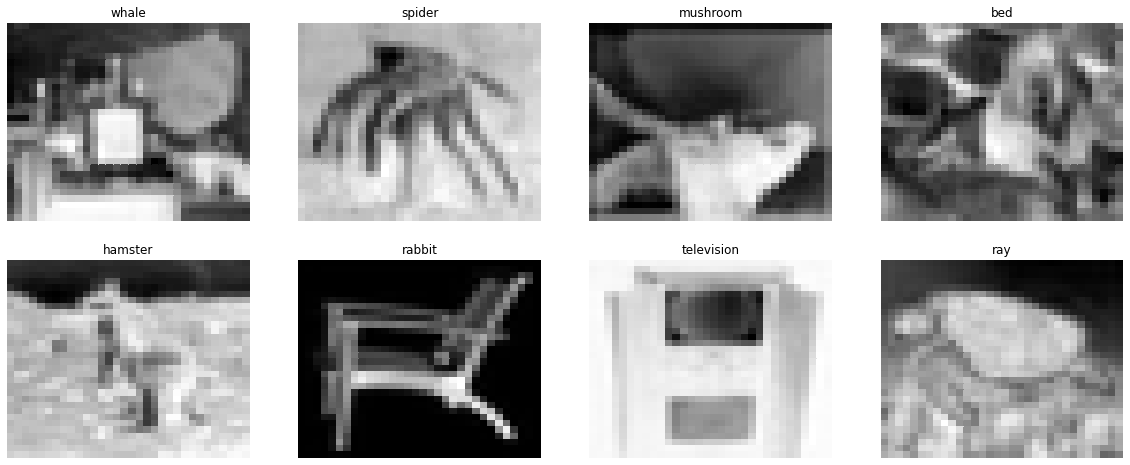

In [56]:
def plot_images(x, labels=None, nrow=2, ncol=4, im_type='image'):
    if im_type == 'filter':
        x = x.transpose(3, 0, 1, 2)  # Transpose to image type
    fig, ax = plt.subplots(nrow, ncol, figsize=(5*ncol, 4*nrow))
    num_samples = x.shape[0]
    num_channels = x.shape[-1]
    for a in ax.ravel():
        j = np.random.choice(num_samples)
        k = np.random.choice(num_channels)
        sns.heatmap(x[j, :, :, k], ax=a, cbar=False, cmap='gray_r')
        if labels is not None:
            a.set_title(labels[j])
        a.set_xticks([])
        a.set_yticks([])

plot_images(x_train, labels=labels_train_noisy)

Finding the index of the label errors using Cleanlab

In [57]:
from __future__ import print_function, absolute_import, division, with_statement
import cleanlab
import numpy as np
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
# To silence convergence warnings caused by using a weak
# logistic regression classifier on image data
import warnings
warnings.simplefilter("ignore")
np.random.seed(477)

In [58]:
actual_label_errors = np.arange(len(y_train_flat))[s != y_train_flat]
print('\nIndices of actual label errors:\n', actual_label_errors)


Indices of actual label errors:
 [    0     1     2 ... 49996 49997 49998]


In [59]:
def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

In [60]:
x_train_gray = grayscale(x_train)
x_test_gray = grayscale(x_test)

In [61]:
x_train_gray = x_train_gray[ : , :,:,0]

In [62]:
x_train_gray_flat = x_train_gray.reshape(50000,1024)
x_test_gray_flat = x_test_gray.reshape(10000,1024)

In [63]:
psx = cleanlab.latent_estimation.estimate_cv_predicted_probabilities(
    x_train_gray_flat, y_train_flat, clf=LogisticRegression(max_iter=1000, multi_class='auto', solver='lbfgs'))
print(psx)

[[2.23968453e-05 4.87729162e-05 1.21845460e-04 ... 3.99396193e-06
  2.35953765e-04 1.42573992e-04]
 [1.39133326e-01 3.96183435e-07 4.80658235e-04 ... 5.74340189e-04
  6.25030219e-05 1.13600477e-02]
 [2.49643339e-02 2.59412905e-04 1.13979645e-03 ... 1.02571100e-04
  7.17212059e-04 1.78854762e-03]
 ...
 [4.18690154e-03 1.06489841e-03 7.56784447e-05 ... 1.48054254e-03
  2.84457044e-04 4.21309764e-03]
 [2.33752305e-03 8.40838179e-03 1.20778640e-03 ... 1.08295474e-03
  4.61338740e-03 3.51164394e-03]
 [1.96914182e-03 1.13148102e-02 2.45032465e-03 ... 4.46513139e-03
  6.69897011e-03 3.41220218e-02]]


In [64]:
s.shape

(50000,)

In [65]:
# STEP 1 - Compute confident joint

# Verify inputs
s = np.asarray(s)
psx = np.asarray(psx)

# Find the number of unique classes if K is not given
K = len(np.unique(s))

# Estimate the probability thresholds for confident counting
# You can specify these thresholds yourself if you want
# as you may want to optimize them using a validation set.
# By default (and provably so) they are set to the average class prob.
thresholds = [np.mean(psx[:,k][s == k]) for k in range(K)] # P(s^=k|s=k)
thresholds = np.asarray(thresholds)

# Compute confident joint
confident_joint = np.zeros((K, K), dtype = int)
for i, row in enumerate(psx):
    s_label = s[i]
    # Find out how many classes each example is confidently labeled as
    confident_bins = row >= thresholds - 1e-6
    num_confident_bins = sum(confident_bins)
    # If more than one conf class, inc the count of the max prob class
    if num_confident_bins == 1:
        confident_joint[s_label][np.argmax(confident_bins)] += 1
    elif num_confident_bins > 1:
        confident_joint[s_label][np.argmax(row)] += 1

# Normalize confident joint (use cleanlab, trust me on this)
confident_joint = cleanlab.latent_estimation.calibrate_confident_joint(
    confident_joint, s)

cleanlab.util.print_joint_matrix(confident_joint)


 Joint Label Noise Distribution Matrix P(s,y) of shape (100, 100)
 p(s,y)	y=0	y=1	y=2	y=3	y=4	y=5	y=6	y=7	y=8	y=9	y=10	y=11	y=12	y=13	y=14	y=15	y=16	y=17	y=18	y=19	y=20	y=21	y=22	y=23	y=24	y=25	y=26	y=27	y=28	y=29	y=30	y=31	y=32	y=33	y=34	y=35	y=36	y=37	y=38	y=39	y=40	y=41	y=42	y=43	y=44	y=45	y=46	y=47	y=48	y=49	y=50	y=51	y=52	y=53	y=54	y=55	y=56	y=57	y=58	y=59	y=60	y=61	y=62	y=63	y=64	y=65	y=66	y=67	y=68	y=69	y=70	y=71	y=72	y=73	y=74	y=75	y=76	y=77	y=78	y=79	y=80	y=81	y=82	y=83	y=84	y=85	y=86	y=87	y=88	y=89	y=90	y=91	y=92	y=93	y=94	y=95	y=96	y=97	y=98	y=99
	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---	---
s=0 |	12	8	14	7	9	12	5	7	13	5	10	6

In [66]:
confident_joint

array([[12,  8, 14, ...,  9, 13,  2],
       [ 1, 33,  3, ...,  2,  1,  3],
       [18, 13, 18, ...,  8, 15,  4],
       ...,
       [ 4, 12,  8, ..., 11,  6,  5],
       [ 4, 12,  6, ...,  9, 27,  5],
       [ 1,  3,  9, ...,  2,  1,  5]])

In [67]:
# STEP 2 - Find label errors

# We arbitrarily choose at least 5 examples left in every class.
# Regardless of whether some of them might be label errors.
MIN_NUM_PER_CLASS = 5
# Leave at least MIN_NUM_PER_CLASS examples per class.
# NOTE prune_count_matrix is transposed (relative to confident_joint)
prune_count_matrix = cleanlab.pruning.keep_at_least_n_per_class(
    prune_count_matrix=confident_joint.T,
    n=MIN_NUM_PER_CLASS,
)

s_counts = np.bincount(s)
noise_masks_per_class = []
# For each row in the transposed confident joint
for k in range(K):
    noise_mask = np.zeros(len(psx), dtype=bool)
    psx_k = psx[:, k]
    if s_counts[k] > MIN_NUM_PER_CLASS:  # Don't prune if not MIN_NUM_PER_CLASS
        for j in range(K):  # noisy label index (k is the true label index)
            if k != j:  # Only prune for noise rates, not diagonal entries
                num2prune = prune_count_matrix[k][j]
                if num2prune > 0:
                    # num2prune'th largest p(classk) - p(class j)
                    # for x with noisy label j
                    margin = psx_k - psx[:, j]
                    s_filter = s == j
                    threshold = -np.partition(
                        -margin[s_filter], num2prune - 1
                    )[num2prune - 1]
                    noise_mask = noise_mask | (s_filter & (margin >= threshold))
        noise_masks_per_class.append(noise_mask)
    else:
        noise_masks_per_class.append(np.zeros(len(s), dtype=bool))

# Boolean label error mask
label_errors_bool = np.stack(noise_masks_per_class).any(axis=0)

 # Remove label errors if given label == model prediction
for i, pred_label in enumerate(psx.argmax(axis=1)):
    # np.all let's this work for multi_label and single label
    if label_errors_bool[i] and np.all(pred_label == s[i]):
        label_errors_bool[i] = False

# Convert boolean mask to an ordered list of indices for label errors
label_errors_idx = np.arange(len(s))[label_errors_bool]
# self confidence is the holdout probability that an example
# belongs to its given class label
self_confidence = np.array(
    [np.mean(psx[i][s[i]]) for i in label_errors_idx]
)
margin = self_confidence - psx[label_errors_bool].max(axis=1)
label_errors_idx = label_errors_idx[np.argsort(margin)]

print('Indices of label errors found by confident learning:')
print('Note label errors are sorted by likelihood of being an error')
print('but here we just sort them by index for comparison with above.')
print(np.array(sorted(label_errors_idx)))

Indices of label errors found by confident learning:
Note label errors are sorted by likelihood of being an error
but here we just sort them by index for comparison with above.
[    0     1     2 ... 49996 49997 49998]


From the above, the index of the labels found by cleanlab is found

In [68]:
y_train_flat.shape

(50000,)

In [69]:
actual_label_errors = np.arange(len(y_train_flat))[s != y_train_flat]
print('\nIndices of actual label errors:\n', actual_label_errors)


Indices of actual label errors:
 [    0     1     2 ... 49996 49997 49998]


In [70]:
len(actual_label_errors)

34074

In [71]:
np.array(sorted(label_errors_idx)).shape

(35561,)

In [72]:
error_match = set(label_errors_idx) & set(actual_label_errors)

In [73]:
len(error_match)

24920

In [40]:
score = sum([e in label_errors_idx for e in actual_label_errors]) / len(actual_label_errors)
print('% actual errors that confident learning found (Recall): {:.0%}'.format(score))
score = sum([e in actual_label_errors for e in label_errors_idx]) / len(label_errors_idx)
print('% confident learning errors that are actual errors (Precision): {:.0%}'.format(score))

% actual errors that confident learning found(Recall): 71%
% confident learning errors that are actual errors(Precision): 73%


From the results above, cleanlab has managed to find the wrongly labelled data with 71% recall and 73% precision. The approach here is to perform sampling by removing from the training data the pictures that were found by cleanlab. It is important to note that since recall and precision stand at about 70%, it means that approximately 30% of the training samples with correct label will be found and the sampled dataset will also have 30# pictures with wrong label

In [ ]:
label_errors_idx.shape

In [107]:
label_errors_idx = np.sort(label_errors_idx)

In [79]:
x_train_filtered = [i for i in x_train if i not in label_errors_idx]

In [83]:
x_train_filtered = np.array(x_train_filtered)

In [84]:
x_train_filtered.shape

(50000, 32, 32, 3)

In [110]:
b = np.array(list(range(50000)))
b= np.array(b)

In [111]:
sampled_index =  [i for i in b if i not in label_errors_idx]

In [115]:
sampled_index = np.array(sampled_index)

In [ ]:
x_train_filtered = x_train[sampled_index]

In [121]:
x_train_filtered.shape

(14439, 32, 32, 3)

In [122]:
y_train_filtered = y_train[sampled_index]

In [123]:
y_train_filtered.shape

(14439, 1)

Building the CNN on Clean Data

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tqdm.keras import TqdmCallback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler

In [17]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

In [18]:
def step_decay(epoch):
    """
    Returns the desired learning rate at epoch
    """
    init_lr = 0.01  # initial
    gamma = 0.5  # decay ratio
    k0 = 20  # decay interval
    lr = init_lr * gamma ** np.floor((epoch)/k0)
    return lr

In [124]:
datagen = ImageDataGenerator(
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    zoom_range=0.1,  # set range for random zoom (1-zoom_range, 1+zoom_range)
    horizontal_flip=True,  # randomly flip images horizontally
)
flow = datagen.flow(x_train, y_train, batch_size=128)
flow_noisy = datagen.flow(x_train, s, batch_size=128)
flow_sampled = datagen.flow(x_train_filtered, y_train_filtered, batch_size = 128)

In [20]:
model3 = Sequential()

model3.add(Conv2D(64, (3, 3), input_shape=(32, 32, 3)))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D((2, 2)))

# Conv 2
# model.add(Dropout(rate=0.25))  # We remove dropouts in conv layers to reduce underfitting
model3.add(Conv2D(128, (3, 3)))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D((2, 2)))

# Conv 3
# model.add(Dropout(rate=0.25))
model3.add(Conv2D(256, (3, 3)))
model3.add(BatchNormalization())
model3.add(Activation('relu'))

# FC 1
model3.add(Flatten())
model3.add(Dropout(rate=0.5))
model3.add(Dense(256))
model3.add(BatchNormalization())
model3.add(Activation('relu'))

# FC 2
model3.add(Dropout(rate=0.5))
model3.add(Dense(128))
model3.add(BatchNormalization())
model3.add(Activation('relu'))

# FC 3
model3.add(Dropout(rate=0.5))
model3.add(Dense(100))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [21]:
model3.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [22]:
 history3 = model3.fit(
     flow,
     epochs=100,
     validation_data=(x_test, y_test),
     verbose=0,
     callbacks=[
         TqdmCallback(verbose=1),
         LearningRateScheduler(step_decay)
     ],
 )

In [29]:
history3_df = pd.DataFrame(history3.history)
history3_df['epoch'] = history3.epoch
history3_df.head()

,loss,acc,val_loss,val_acc,lr,epoch
0,4.128148,0.06678,4.072527,0.0809,0.01,0
1,3.708173,0.11828,3.559871,0.1554,0.01,1
2,3.514442,0.14948,3.377745,0.1806,0.01,2
3,3.357575,0.17696,3.040954,0.2402,0.01,3
4,3.240027,0.20084,2.964046,0.2529,0.01,4


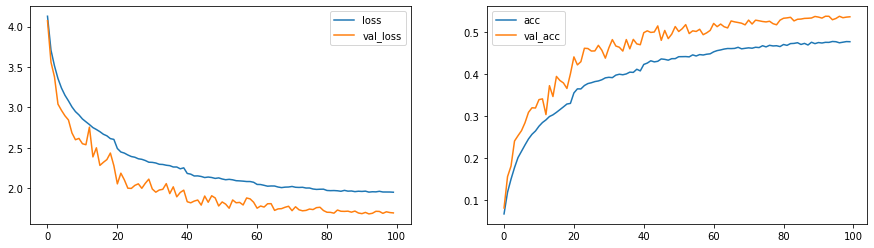

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
history3_df.plot(y=['loss', 'val_loss'], ax=ax[0])
history3_df.plot(y=['acc', 'val_acc'], ax=ax[1])

Running the CNN on the data with noisy labels

In [24]:
model4 = Sequential()

model4.add(Conv2D(64, (3, 3), input_shape=(32, 32, 3)))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling2D((2, 2)))

# Conv 2
# model.add(Dropout(rate=0.25))  # We remove dropouts in conv layers to reduce underfitting
model4.add(Conv2D(128, (3, 3)))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling2D((2, 2)))

# Conv 3
# model.add(Dropout(rate=0.25))
model4.add(Conv2D(256, (3, 3)))
model4.add(BatchNormalization())
model4.add(Activation('relu'))

# FC 1
model4.add(Flatten())
model4.add(Dropout(rate=0.5))
model4.add(Dense(256))
model4.add(BatchNormalization())
model4.add(Activation('relu'))

# FC 2
model4.add(Dropout(rate=0.5))
model4.add(Dense(128))
model4.add(BatchNormalization())
model4.add(Activation('relu'))

# FC 3
model4.add(Dropout(rate=0.5))
model4.add(Dense(100))

In [25]:
model4.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [26]:
 history4 = model4.fit(
     flow_noisy,
     epochs=100,
     validation_data=(x_test, y_test),
     verbose=0,
     callbacks=[
         TqdmCallback(verbose=1),
         LearningRateScheduler(step_decay)
     ],
 )

In [27]:
model4.evaluate(x_test, y_test)
history4_df = pd.DataFrame(history4.history)
history4_df['epoch'] = history4.epoch
history4_df.head()

10000/10000 [==============================] - 1s 108us/sample - loss: 3.3018 - acc: 0.1447


,loss,acc,val_loss,val_acc,lr,epoch
0,4.252368,0.04798,4.675206,0.0240,0.01,0
1,4.056591,0.06668,4.568752,0.0309,0.01,1
2,3.957769,0.08008,4.652767,0.0281,0.01,2
3,3.877982,0.09456,4.438106,0.0474,0.01,3
4,3.816882,0.10354,4.397703,0.0531,0.01,4


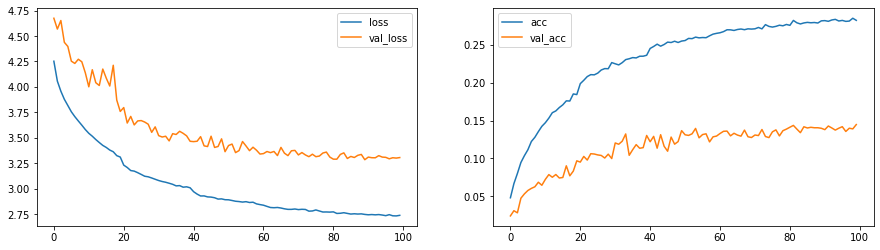

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
history4_df.plot(y=['loss', 'val_loss'], ax=ax[0])
history4_df.plot(y=['acc', 'val_acc'], ax=ax[1])

Running the CNN with the newly sampled CIFAR 100 dataset

In [125]:
model5 = Sequential()

model5.add(Conv2D(64, (3, 3), input_shape=(32, 32, 3)))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling2D((2, 2)))

# Conv 2
# model.add(Dropout(rate=0.25))  # We remove dropouts in conv layers to reduce underfitting
model5.add(Conv2D(128, (3, 3)))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling2D((2, 2)))

# Conv 3
# model.add(Dropout(rate=0.25))
model5.add(Conv2D(256, (3, 3)))
model5.add(BatchNormalization())
model5.add(Activation('relu'))

# FC 1
model5.add(Flatten())
model5.add(Dropout(rate=0.5))
model5.add(Dense(256))
model5.add(BatchNormalization())
model5.add(Activation('relu'))

# FC 2
model5.add(Dropout(rate=0.5))
model5.add(Dense(128))
model5.add(BatchNormalization())
model5.add(Activation('relu'))

# FC 3
model5.add(Dropout(rate=0.5))
model5.add(Dense(100))

In [126]:
model5.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [128]:
 history5 = model5.fit(
     flow_sampled,
     epochs=100,
     validation_data=(x_test, y_test),
     verbose=0,
     callbacks=[
         TqdmCallback(verbose=1),
         LearningRateScheduler(step_decay)
     ],
 )

In [129]:
model5.evaluate(x_test, y_test)
history5_df = pd.DataFrame(history5.history)
history5_df['epoch'] = history5.epoch
history5_df.head()

10000/10000 [==============================] - 1s 106us/sample - loss: 2.3530 - acc: 0.3945


,loss,acc,val_loss,val_acc,lr,epoch
0,4.277967,0.052150,9.636828,0.0189,0.01,0
1,3.936031,0.084978,5.300455,0.0315,0.01,1
2,3.795539,0.104578,4.729023,0.0604,0.01,2
3,3.700802,0.123277,4.030087,0.0950,0.01,3
4,3.616960,0.135536,3.815457,0.1052,0.01,4


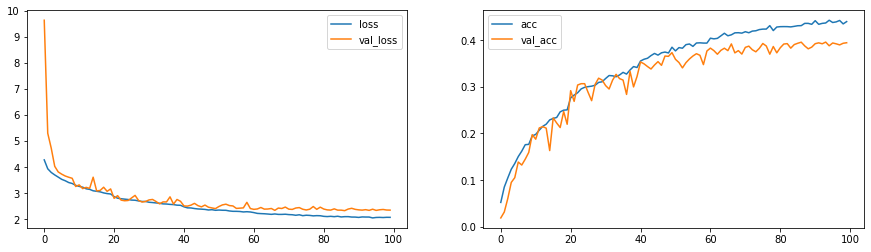

In [130]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
history5_df.plot(y=['loss', 'val_loss'], ax=ax[0])
history5_df.plot(y=['acc', 'val_acc'], ax=ax[1])

From here, we can see that sampling the dataset using cleanlab has a significant improvement on the noisy data. However, as mentioned in the Selfie paper, it has the criticism of not learning the full training data which serves as a motivation for the authors to explore selfie.